## Preprocessing settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#in_path = '/content/drive/MyDrive/Colab Notebooks/rnnrec/data/ml-1m-raw/'
in_path = './data/ml-1m-raw/'
ratings_file = in_path + 'ratings.dat'

## Load data file

In [2]:
# Load the input file in memory
raw = []
with open(ratings_file, 'r') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw.append(line_list)

## Data's skewness

users` max freq: 2314
items` max freq: 3428


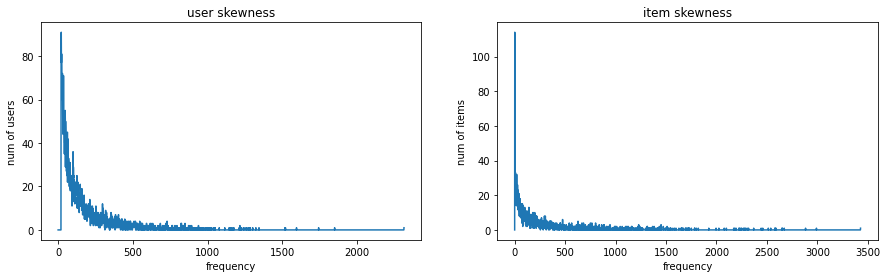

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,4)

raw = np.array(raw, dtype=int)
user_freq = np.bincount(raw[:, 0]) # [user1's freq, user2's freq, ..., usern's freq]
user_freq = [i for i in user_freq if i>0] # exclude dummy users
user_freq = np.bincount(user_freq)
user_x_axis = np.array(range(len(user_freq)))
print(f'users` max freq: {len(user_freq)-1}')

item_freq = np.bincount(raw[:, 1]) #[item1's freq, item2's freq, ..., itemm's freq]
item_freq = [i for i in item_freq if i>0] # exclude dummy items
item_freq = np.bincount(item_freq)
item_x_axis = np.array(range(len(item_freq)))
print(f'items` max freq: {len(item_freq)-1}')

fig, axs = plt.subplots(1, 2)
axs[0].plot(user_x_axis, user_freq)
axs[0].set_title('user skewness')
axs[0].set_xlabel('frequency')
axs[0].set_ylabel('num of users')
axs[1].plot(item_x_axis, item_freq)
axs[1].set_title('item skewness')
axs[1].set_xlabel('frequency')
axs[1].set_ylabel('num of items')
plt.show()

## Sort interactions by (u_id, time)

In [7]:
raw_sorted = np.array(sorted(raw, key=lambda x: (x[0], x[3])))
print(f'num of interactions: {len(raw_sorted)}')

num of interactions: 1000209


## Assign new ids

In [8]:
user_ids = list()
item_ids = list()
user_map = dict() # raw -> new
item_map = dict() # raw -> new

user_ids = np.unique(raw[:, 0])
item_ids = np.unique(raw[:, 1])

user_map = {v: i for (i, v) in enumerate(user_ids)}
item_map = {v: i for (i, v) in enumerate(item_ids)}

new_sorted = [[user_map[u], item_map[i]] for (u, i)
              in zip(raw_sorted[:, 0], raw_sorted[:, 1])] # new array

## Construct dictionary of side information

In [9]:
movies_file = in_path + 'movies.dat'
meta_dict = dict()
        
with open(movies_file, 'r',  encoding='ISO-8859-1') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw_id = int(line_list[0].strip())
        try:
            new_id = item_map[raw_id]
        except KeyError:
            continue
        meta_dict[new_id] = [line_list[1].strip(), line_list[2].strip()]

## Construct train/test lists

In [10]:
ratio = 0.8

In [11]:
new_sorted = np.array(new_sorted)
split_idx = np.flatnonzero(np.diff(new_sorted[:, 0])) + 1

In [12]:
trn_list, test_list = [], []
for arr in np.array_split(new_sorted, split_idx):
  split_i = round(len(arr) * ratio)
  trn_list.append(arr[:split_i, :])
  test_list.append(arr[split_i:, :])

## Data instance parameters

In [13]:
feed_len = 5
target_len = 3
neg_samples = 10

## Make data instances

In [14]:
"""
If user 0 has interacted with items [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
we have trn_arr and test_arr as follows.
trn_arr (80%):
[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9]]
test_arr (20%):
[[0, 10],
 [0, 11]]

Then, the returned instance matrices for "sequence length 5", "target length 3",
and "number of negative samples 10" are as follows.
trn_users:
[0, 0]
trn_feed_sequences:
[[1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6]]
trn_positive_targets:
[[6, 7, 8]
 [7, 8, 9]]
trn_negative_targets:
[[n1, n2, ..., n10],
 [n1', n2', ..., n10']]
test_users:
0
test_feed_sequences:
[5, 6, 7, 8, 9]
test_targets:
[10, 11]
"""

trn_users = []
trn_feed_sequences = []
trn_positive_targets = []
trn_negative_targets = []

test_users = []
test_feed_sequences = []
test_targets = []

In [15]:
for trn_arr, test_arr in zip(trn_list, test_list):
  trn_split = np.lib.stride_tricks.sliding_window_view(trn_arr, window_shape=feed_len+target_len, axis=0)
  trn_users.append(trn_split[:, 0, 0])
  trn_feed_sequences.append(trn_split[:, 1, :feed_len])
  trn_positive_targets.append(trn_split[:, 1, feed_len:])
  trn_negative_targets.append(np.random.randint(len(item_map), size=(trn_split.shape[0], neg_samples)))
  
  test_users.append(test_arr[0, 0])
  test_feed_sequences.append(trn_arr[-feed_len:, 1])
  test_targets.append(test_arr[:, 1])

In [16]:
trn_users = np.concatenate(trn_users, axis=0)
trn_feed_sequences = np.concatenate(trn_feed_sequences, axis=0)
trn_positive_targets = np.concatenate(trn_positive_targets, axis=0)
trn_negative_targets = np.concatenate(trn_negative_targets, axis=0)
test_users = np.array(test_users)
test_feed_sequences = np.stack(test_feed_sequences)
# We cannot construct test_targets as an array since the number of targets is different for each user

x_train = np.concatenate((trn_users[:, np.newaxis], trn_feed_sequences), axis=1)
x_test = np.concatenate((test_users[:, np.newaxis], test_feed_sequences), axis=1)
targets_train = np.concatenate((trn_positive_targets, trn_negative_targets), axis=1)

In [17]:
x_train

array([[   0, 2969, 1178, 1574,  957, 2147],
       [   0, 1178, 1574,  957, 2147, 1658],
       [   0, 1574,  957, 2147, 1658, 3177],
       ...,
       [6039, 3493, 3441, 1124, 2410, 2443],
       [6039, 3441, 1124, 2410, 2443, 1342],
       [6039, 1124, 2410, 2443, 1342, 3271]])

In [18]:
x_test

array([[   0, 1107,  580, 2205, 1421,  513],
       [   1, 1826, 2086, 1271,  627, 2234],
       [   2, 3189, 1295, 2785, 1212, 3379],
       ...,
       [6037, 2872,  225, 1059, 1133, 1204],
       [6038,  740, 1011, 1314,  193,   47],
       [6039, 1342, 3271, 2111, 3107,  256]])

In [19]:
targets_train

array([[1658, 3177, 2599, ..., 2963, 1099, 1317],
       [3177, 2599, 1117, ..., 2058, 1902, 2227],
       [2599, 1117, 1104, ..., 1971,  237, 2012],
       ...,
       [1342, 3271, 2111, ..., 2449, 1806, 2677],
       [3271, 2111, 3107, ...,   66,   22, 3516],
       [2111, 3107,  256, ..., 3506,  444,  468]])

## Model parameters

In [20]:
lr = 1e-3
batch_size = 1000
epochs = 100
emb_dim = 50
hid_dim = 50
epsilon = 1e-10 # This prevents the occurrence of log(0)

## Define a model



In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, concatenate

class my_model(tf.keras.Model):
    def __init__(self, num_items, num_users, emb_dim, hid_dim):
        super(my_model, self).__init__(self)
        self.item = Embedding(num_items, emb_dim)
        self.user = Embedding(num_users, emb_dim)
        self.lstm = LSTM(units=hid_dim)
        self.lstm_dense = Dense(emb_dim)
        self.final1 = Dense(emb_dim, activation='relu')
        self.final2 = Dense(num_items)
   
    def call(self, x):
        user = x[:, 0]
        item = x[:, 1:]
        item_out = self.lstm_dense(self.lstm(self.item(item)))
        user_embedding = self.user(user)
        concat = concatenate([item_out, user_embedding])
        model_out = self.final2(self.final1(concat))
        return model_out

model = my_model(len(item_map), len(user_map), emb_dim, hid_dim)

In [23]:
def rec_loss(targets, y_pred):
  logits = tf.gather(y_pred, targets, axis=1, batch_dims=1)
  pos_logits, neg_logits = logits[:, :target_len], logits[:, target_len:]
  pos_loss = -tf.math.reduce_sum(tf.math.log(tf.clip_by_value(tf.math.sigmoid(pos_logits),
                                                              clip_value_min=epsilon, clip_value_max=1)), axis=1)
  neg_loss = -tf.math.reduce_sum(tf.math.log(tf.clip_by_value(1 - tf.math.sigmoid(neg_logits),
                                                              clip_value_min=epsilon, clip_value_max=1)), axis=1)
  return tf.math.reduce_mean(pos_loss + neg_loss)

In [24]:
model.compile(optimizer='adam', loss=rec_loss)

## Train the model

In [25]:
model.fit(x_train, targets_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
758/758 [==============================] - 29s 36ms/step - loss: 5.2503
Epoch 2/100
758/758 [==============================] - 27s 36ms/step - loss: 4.2669
Epoch 3/100
758/758 [==============================] - 29s 38ms/step - loss: 3.5988
Epoch 4/100
758/758 [==============================] - 27s 36ms/step - loss: 3.2142
Epoch 5/100
758/758 [==============================] - 28s 36ms/step - loss: 2.9094
Epoch 6/100
758/758 [==============================] - 26s 35ms/step - loss: 2.7238
Epoch 7/100
758/758 [==============================] - 27s 35ms/step - loss: 2.5909
Epoch 8/100
758/758 [==============================] - 26s 34ms/step - loss: 2.4881
Epoch 9/100
758/758 [==============================] - 26s 34ms/step - loss: 2.4042
Epoch 10/100
758/758 [==============================] - 26s 34ms/step - loss: 2.3332
Epoch 11/100
758/758 [==============================] - 26s 35ms/step - loss: 2.2717
Epoch 12/100
758/758 [==============================] - 27s 36ms/step - lo

## Evaluate the model

In [26]:
def compute_precision(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(pred)

def compute_recall(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(targets)

def compute_ap(predictions, targets, k):
    if len(predictions) > k:
        predictions = predictions[:k]
    score = 0.
    num_hits = 0.
    for i, p in enumerate(predictions):
        if p in targets:
            num_hits += 1.
            score += num_hits / (i+1)
    return score / min(len(targets), k)

def evaluate(preds, gts, k=10):
    precs = [compute_precision(p, t, k=k) for (p, t) in zip(preds, gts)]
    recalls = [compute_recall(p, t, k=k) for (p, t) in zip(preds, gts)]
    aps = [compute_ap(p, t, k=k) for (p, t) in zip(preds, gts)]
    return float(sum(precs) / len(precs)), \
            float(sum(recalls) / len(recalls)), \
            float(sum(aps) / len(aps))

In [27]:
preds = tf.argsort(-model.call(x_test)).numpy()
prec, recall, ap = evaluate(preds, test_targets, k=10)
print(f'Prec@10: {prec:.4f}, Recall@10: {recall:.4f}, Map@10: {ap:.4f}')

Prec@10: 0.0723, Recall@10: 0.0379, Map@10: 0.0297


## Qualitative evaluation

In [28]:
from random import randint
idx = randint(0, len(test_users))
history = [meta_dict[i] for i in test_feed_sequences[idx]]
predict = [meta_dict[i] for i in preds[idx][:10]]
real = [meta_dict[i] for i in test_targets[idx]]

def mask2str(mask):
    return 'O' if mask else 'X'

predict_mask = [check in test_targets[idx] for check in preds[idx][:10]]
real_mask = [check in preds[idx][:10] for check in test_targets[idx]]
predict_mask = [mask2str(mask) for mask in predict_mask]
real_mask = [mask2str(mask) for mask in real_mask]

print('==== Watched history ====')
for i in history:
    print(i)
    
print('==== Real targets ===')
for m, v in zip(real_mask, real):
    print(f'{[m]} {v}')


print('=== Predicted targets ===')
for m, v in zip(predict_mask, predict):
    print(f'{[m]} {v}')

==== Watched history ====
['Dark City (1998)', 'Film-Noir|Sci-Fi|Thriller']
['Heavy Metal (1981)', 'Action|Adventure|Animation|Horror|Sci-Fi']
['Robocop (1987)', 'Action|Crime|Sci-Fi']
['Jurassic Park (1993)', 'Action|Adventure|Sci-Fi']
['Flight of the Navigator (1986)', "Adventure|Children's|Sci-Fi"]
==== Real targets ===
['X'] ['Adventures of Buckaroo Bonzai Across the 8th Dimension, The (1984)', 'Adventure|Comedy|Sci-Fi']
['X'] ["Logan's Run (1976)", 'Action|Adventure|Sci-Fi']
['O'] ['X-Files: Fight the Future, The (1998)', 'Mystery|Sci-Fi|Thriller']
['X'] ['Dreamscape (1984)', 'Adventure|Crime|Sci-Fi|Thriller']
['X'] ['54 (1998)', 'Drama']
['X'] ['American Pie (1999)', 'Comedy']
['X'] ['10 Things I Hate About You (1999)', 'Comedy|Romance']
['X'] ['American Beauty (1999)', 'Comedy|Drama']
['X'] ['Baby Geniuses (1999)', 'Comedy']
['X'] ['Austin Powers: The Spy Who Shagged Me (1999)', 'Comedy']
=== Predicted targets ===
['X'] ['Until the End of the World (Bis ans Ende der Welt) (1991)